# Functions

**Generate the B graph**

In [56]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import random
from sklearn.metrics import f1_score
from time import time
import matplotlib.pyplot as plt
from numpy.ma.extras import average
from sklearn.metrics import confusion_matrix
import csv
import itertools

In [ ]:
np.random.seed(0)

In [57]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rcdefaults()

### Data Generation Functions

In [58]:
def B_mat_symmetric(a, p):
    '''To generate a symmetric toeplitz matrix with a given vector 'a' '''
    # Vector 'a' can only be of length p (odd length indexing from 0 to p-1 and center at 0)
    # Initialize a zeros matrix of size nxn
    result = np.zeros((p, p))

    # Fill in the main diagonal with center element of a
    np.fill_diagonal(result, a[0])

    # Fill in sub/super-diagonals (below the main diagonal)
    for i in range(1, p):
        np.fill_diagonal(result[i:], -1*a[i]) # Sub-diagonals
        np.fill_diagonal(result[:,i:], -1*a[i]) # Super-diagonals
    return result


def B_mat_lowertriangular(a, p):
    '''To generate a lower triangular toeplitz matrix with a given vector 'a' '''
    # Vector 'a' can only be of length p (odd length indexing from 0 to p-1 and center at 0)
    # Initialize a zeros matrix of size nxn
    result = np.zeros((p, p))

    # Fill in the main diagonal with center element of a
    np.fill_diagonal(result, a[0])

    # Fill in sub/diagonals (below the main diagonal)
    for i in range(1, p):
        np.fill_diagonal(result[i:], -1*a[i]) # Sub-diagonals
    return result


def cov_x(p):
    """ Generate the covariance matrix for x"""
    sigma_x = np.eye(p)
    return sigma_x


def cov_y(sigma_x, B):
    """ Generate covariance matrix for Y i.e. (B^(-1).X.B^(-T)) since Y=B^(-1).X"""
    B_inv = np.linalg.solve(B, np.eye(B.shape[0]))
    sigma_y = B_inv@sigma_x@B_inv.T
    return sigma_y


def generate_y(mean_y, sigma_y, n_samples):
    """ Generate samples of Y"""
    y_samples = multivariate_normal.rvs(mean=mean_y, cov=sigma_y, size=n_samples)
    return y_samples

def samp_cov2(y_samples):
    n_samples = len(y_samples)
    samp_cov_y = np.sum(np.array([np.outer(y_samples[i],y_samples[i]) for i in range(n_samples)]), axis=0)/n_samples 
    return samp_cov_y
    
def samp_cov(y_samples):
    """ Generating sample covariance matrix """
    # n_samples = len(y_samples)
    # samp_cov_y = np.sum(np.array([np.outer(y_samples[i],y_samples[i]) for i in range(n_samples)]), axis=0)/n_samples 
    # return samp_cov_y
    # TODO: check if bias=True divides the sum by n_samples
    return np.cov(y_samples, rowvar=False, bias=True)


def soft(x, y):
    return np.sign(x) * np.maximum(np.abs(x) - y, 0)


def threshold(vec, threshold_value=0.002):
    vec1 = vec.copy()
    vec1[np.abs(vec) < threshold_value] = 0
    return vec1


def binarize_matrix(matrix):
    '''Converts non-zero elements to 1 and keeps zeros as zeros.'''
    binary_matrix = np.where(matrix != 0, 1, 0)
    return binary_matrix


def compute_recovery_rate_numpy(a_binary, true_a_binary):
    joint_ones = np.sum((a_binary == 1) & (true_a_binary == 1)) # True positives + False positives
    ones_true_a = np.sum(true_a_binary == 1) # True positives
    if ones_true_a == 0:
        return 0
    return joint_ones / ones_true_a


def create_sparse_vec_pos_def_2(dim, nonzeros, diag=20):
    ''' Function to create sparse vector(p x 1) which can generate symmetric +ve definite toeplitz matrix'''
    vec = np.zeros((dim,))
    vec[0] = diag
    nonzeros -= 1
    # selection of indicies with the non-zero entry (random selection)
    non_zero_indices = random.sample(range(1,dim),nonzeros)
    for idx in non_zero_indices:
        # Randomly assign values to non-zero entries 
        vec[idx] = random.randint(1,5)
    return vec


### Different functions for ADMM ###

def f1(a, S, sigma_x, rho, a2, mu1, regularized = False):
    """ Function evaluation for Newton method with regularization term based on ADMM
       TODO: verify this Tr[S.Theta_y] - logdet(Theta_y) + rho/2*||a1 - a2 + mu1||_1"""
    p = S.shape[0]
    a.reshape((-1,))
    B = B_mat_symmetric(a, p)
    theta_x = np.linalg.solve(sigma_x, np.eye(p))
    if regularized:
        # Added [1:] since we don't want to regularize a0
        reg_term = (rho/2)*np.linalg.norm(a[1:]-a2+mu1)
    else:
        reg_term = 0
    return np.trace(S@B.T@theta_x@B)-np.log(np.linalg.det(B.T@theta_x@B))+reg_term 


def f2(a, lam):
    """ Function evaluation of regularization term """
    return lam*np.linalg.norm(a[1:],1)
    
    
def f(a, S, sigma_x):
    a.reshape((-1,))
    B = B_mat_symmetric(a, S.shape[0])
    sigma_x_inv = np.linalg.solve(sigma_x, np.eye(S.shape[0]))
    return np.trace(S@B.T@sigma_x_inv@B) - np.log(np.linalg.det(B.T@sigma_x_inv@B))

In [59]:
def make_T_matrices(p, symmetric=False):
    """
    Returns a list [T0, T1, …, T(p-1)]
    for every j!=0 T[j] is a pxp matrix with jth super and subdiagonals with entries 1
    for j=0 its an Identity matrix
    """
    T_list = []
    I = np.eye(p)
    T_list.append(I)
    for j in range(1, p):
        M = np.zeros((p, p))
        # sub‑diagonal
        M[np.arange(j, p), np.arange(0, p-j)] = -1
        if symmetric:
            # super‑diagonal
            M[np.arange(0, p-j), np.arange(j, p)] = -1
        T_list.append(M)
    return T_list


Metrics

In [64]:
def kll(a, a_hat, sigma_x):
    ''' Computing the KL loss for the covariance matrices of Y'''
    p = len(a)
    B = B_mat_symmetric(a, p)
    B_hat = B_mat_symmetric(a_hat, p)
    sigma_y = cov_y(sigma_x, B)
    sigma_y_hat = cov_y(sigma_x, B_hat)
    theta_y_hat = np.linalg.solve(sigma_y_hat, np.eye(p))
    theta_y = np.linalg.solve(sigma_y, np.eye(p))
    return np.trace(sigma_y@theta_y_hat) - np.log(np.linalg.det(sigma_y@theta_y_hat)) - p

def rkll(a, a_hat, sigma_x):
    ''' Computing the reverse KL loss for the covariance matrices of Y'''
    return kll(a_hat, a, sigma_x)

def rte(a, a_hat, sigma_x):
    ''' Computing the relative trace error loss for the precision matrix'''
    p = len(a)
    B = B_mat_symmetric(a, p)
    B_hat = B_mat_symmetric(a_hat, p)
    # sigma_y = cov_y(sigma_x, B)
    # sigma_y_hat = cov_y(sigma_x, B_hat)
    theta_y_hat = B_hat.T@B_hat
    theta_y = B.T@B
    return abs(1 - (np.trace(theta_y_hat)/np.trace(theta_y)))

def norm_loss(a, a_hat, sigma_x):
    ''' Computing the norm loss for the precision matrix'''
    p = len(a)
    B = B_mat_symmetric(a, p)
    B_hat = B_mat_symmetric(a_hat, p)
    # sigma_y = cov_y(sigma_x, B)
    # sigma_y_hat = cov_y(sigma_x, B_hat)
    # theta_y_hat = np.linalg.solve(sigma_y_hat, np.eye(p))
    # theta_y = np.linalg.solve(sigma_y, np.eye(p))
    theta_y_hat = B_hat.T@B_hat
    theta_y = B.T@B
    fro = np.linalg.norm(theta_y-theta_y_hat,ord='fro')
    spe = np.linalg.norm(theta_y-theta_y_hat,ord=2)
    l1 = np.linalg.norm(theta_y-theta_y_hat,ord=1)
    return fro, spe, l1

def scores(a, a_hat, threshold_value):
    ''' Computing the support recovery based scores for the precision matrix'''
    a_thr = threshold(a_hat, threshold_value=threshold_value) # Apply the threshold
    a_binary = binarize_matrix(a_thr)  # Change the output to a binary matrix to check for support recovery
    true_a_binary = binarize_matrix(a)  # True Support Vector
    cm = confusion_matrix(true_a_binary, a_binary)
    tn,fp,fn,tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    accuracy = (tn + tp)/np.sum(cm)
    specificity = (tn)/(tn + fp) # TN/(TN+FP)
    sensitivity = (tp)/(tp + fn) # TP/(TP+FN)
    MCC = ((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return accuracy, specificity, sensitivity, MCC, cm

### Gradient Computation

In [6]:
def grad_f(x, S, sigma_x, rho, a2, mu1, T_list, regularized = False):
    ''' Computing gradient for f1(x) = Tr(S B(x) T B(x)) + log(det(B(x) T B(x)))
        both regularized and unregularized, where B is symmetric'''
    p = S.shape[0] # Dimensions
    # B = B_mat_symmetric(x, p) # Generating B matrix with a given x
    B = sum(x[j]*T_list[j] for j in range(p))
    B_inv = np.linalg.solve(B, np.eye(p))
    theta_x = np.linalg.solve(sigma_x, np.eye(p))
    
    if regularized:
        k = np.zeros_like(x)
        k[1:] = x[1:]-a2+mu1
    else:
        k = np.zeros_like(x)
    # TODO: check if np.einsum() is better here
    gradient = np.zeros((p,))
    for i in range(p):
            Ti = T_list[i] 
            gradient[i] = 2*np.trace((S@B@theta_x@Ti) - (B_inv@Ti)) + (rho*k[i])
    return gradient


def hessian_f(x, S, sigma_x, rho,T_list, regularized = False):
    ''' Computing Hessian for f1(x) = Tr(S B(x) T B(x)) + log(det(B(x) T B(x)))
        both regularized and unregularized, where B is symmetric'''
    p = S.shape[0]
    # B = B_mat_symmetric(x, p)
    B = sum(x[j]*T_list[j] for j in range(p))
    B_inv = np.linalg.solve(B, np.eye(p))  
    # B_inv = np.linalg.solve(B, stack all Tis)  
    theta_x = np.linalg.solve(sigma_x, np.eye(p))
    
    hessian = np.zeros((p,p))
    for i in range(p):
        Ti = T_list[i]
        for j in range(p):
            Tj = T_list[j]
            hessian[i,j] = 2*(np.trace(S@Ti@theta_x@Tj) + np.trace(B_inv@Ti@B_inv@Tj))
    if regularized:
        reg = rho*np.eye(p)
        reg[0,0] = 0
        hessian+=reg
    return hessian

In [7]:
def compute_gH(x, S, rho, a2, mu1, T_list, B, B_inv, theta_x, regularized = False):
    p=S.shape[0]
    # compute gradient
    if regularized:
        k = np.zeros_like(x)
        k[1:] = x[1:]-a2+mu1
    else:
        k = np.zeros_like(x)
    gradient = np.zeros((p,))
    for i in range(p):
            Ti = T_list[i] 
            gradient[i] = 2*np.trace((S@B@theta_x@Ti) - (B_inv@Ti)) + (rho*k[i])

    # compute hessian
    hessian = np.zeros((p,p))
    for i in range(p):
        Ti = T_list[i]
        for j in range(p):
            Tj = T_list[j]
            hessian[i,j] = 2*(np.trace(S@Ti@theta_x@Tj) + np.trace(B_inv@Ti@B_inv@Tj))
    if regularized:
        reg = rho*np.eye(p)
        reg[0,0] = 0
        hessian+=reg

    return gradient, hessian

###  Newtons Method

In [67]:
def compute_newton_step(gradient, hessian):
    """
    Computes the Newton step and decrement.

    Parameters:
    gradient (np.array): Gradient vector.
    hessian (np.array): Hessian matrix.

    Returns:
    delta_x_nt (np.array): Newton step.
    lambd (float): Newton decrement.
    """
    delta_x_nt = -np.linalg.solve(hessian, gradient)  # Newton step
    lambd_sqr = np.dot(gradient.T, hessian@gradient)  # Newton decrement
    return delta_x_nt, lambd_sqr

def backtracking_line_search(f, gradient, x, delta_x_nt, S, sigma_x, rho, a2, mu1,
                             regularized=False, alpha=0.01, beta=0.5):
    """
    Backtracking line search to ensure sufficient decrease.

    Parameters:
    f (function): Function to minimize.
    gradient (np.array): Gradient vector.
    x (np.array): Current point.
    delta_x_nt (np.array): Newton step.
    alpha (float): Alpha parameter for backtracking.
    beta (float): Beta parameter for backtracking.

    Returns:
    t (float): Step size.
    """
    t = 1  # Start with full step size
    p = S.shape[0]
    x_ = x + t * delta_x_nt
    # TODO: check if choelsky decomposition method of checking psd constraint is actually faster and reliable
    e_val, _ = np.linalg.eig(B_mat_symmetric(x_, p))
    i = 0
    while not np.all(e_val>0): 
        t *= beta # Reduce step size so that x + del_x is PSD
        x_ = x + t * delta_x_nt
        e_val, _ = np.linalg.eig(B_mat_symmetric(x_, p))
        i+=1
        if(i%5==0):
            print(f"   PSD-loop  iter={i:2d}  t={t:.2e}  λ_min={e_val[0]:.2e}")
        if i>20:
            t = 0
            print('Backtracking line search (I) went beyond 20 iterations')
            break
    x_ = x + t * delta_x_nt
    i = 0
    while (f(x_,S,sigma_x,rho,a2,mu1,regularized=regularized)\
           >f(x,S,sigma_x,rho,a2,mu1,regularized=regularized)\
           + alpha*t*np.dot(gradient.T,delta_x_nt)):
        t *= beta  # Reduce step size
        x_ = x + t * delta_x_nt
        # if(i%5==0):
            # print(f"   Armijo    t={t:.2e}")
        if (i>20) or (t==0):
            t = 0
            print('Backtracking line search (II) went beyond 20 iterations')
            break
    return t


def projection_Rp(x):
    y = np.maximum(x, np.zeros_like(x))
    return y


def newton_method(f, x0, S, sigma_x, rho, a2, mu1, T_list, epsilon=1e-6, alpha=0.01, beta=0.5,
                  regularized=False, backtracking=False, projection=False):
    """
    Implements Newton's method for optimization.

    Parameters:
    f (function): Function to minimize.
    grad_f (function): Gradient function.
    hessian_f (function): Hessian function.
    x0 (np.array): Initial point.
    epsilon (float): Stopping criterion for Newton decrement.
    alpha (float): Alpha parameter for backtracking.
    beta (float): Beta parameter for backtracking.

    Returns:
    x (np.array): Optimized point.
    """
    x = x0
    i = 0
    p=S.shape[0]
    theta_x = np.linalg.solve(sigma_x, np.eye(p))

    while True:
        B = sum(x[j]*T_list[j] for j in range(p))
        B_inv = np.linalg.solve(B, np.eye(p))
        
        gradient,hessian = compute_gH(x, S, rho, a2, mu1, T_list, B, B_inv,theta_x, regularized=regularized)
        
        # Compute Newton step and decrement
        delta_x_nt, lambd_sqr = compute_newton_step(gradient, hessian)
        
        # Stopping criterion
        if lambd_sqr / 2 <= epsilon:
            print('Stopping Criteria Met at iteration ', i)
            print(lambd_sqr, delta_x_nt)
            # print(i)
            break

        # Backtracking line search
        if backtracking:
            # print("line search")
            t = backtracking_line_search(f, gradient, x, delta_x_nt, S, sigma_x, rho, a2, mu1,
                                         regularized=regularized, alpha=alpha, beta=beta)
            print(f"line search step size t = {t:.2e}")
        else:
            t = 1
        # print(t)
            
        # Update x
        x_old = x.copy()
        x = x + t*delta_x_nt

        # Project x on R+
        if projection:
            x = projection_Rp(x)
        
        if i%10==0:
            # print(lambd_sqr, delta_x_nt)
            # print(i)
            print('Newton algorithm finished 10 iterations, lambda_sqr: ', lambd_sqr)
            
        if (i>=20):
            print('Newton algorithm finished 50 iterations')
            break
        
        if (i>1) and (np.linalg.norm(x_old-x)<=epsilon):
            print('not much change in x observed')
            print(i)
            break
        i+=1
    return x


### Pseudo Version of ADMM (Since f1 is not in closed form)

#### ADMM

In [9]:
def ADMM_newton(f, iterations, rho, lambda_param, S, sigma_x, a, T_list, epsilon=1e-6,
                alpha=0.5, beta=0.7, regularized=False, backtracking=True,
                projection=True, perturbed=False, tol=1e-4):
    p = S.shape[0]
    e0 = np.zeros((p,))
    e0[0] = 1
    a1 = e0.copy()
    a2 = np.zeros((p-1,))
    mu1 = np.zeros((p-1,))
    if perturbed:
        a1 = a + 0.1*np.random.randn(p)
        a2 = a[1:] + 0.1*np.random.randn(p-1)
    if regularized:
        print('Regularized - ADMM + Newton')
        for i in range(iterations):       
            print('='*50, "iteration ", i, '='*50)
            a2_old = a2.copy()
            a1_ = newton_method(f, a1, S, sigma_x, rho, a2, mu1, T_list, epsilon=epsilon,
                                alpha=alpha, beta=beta, regularized=regularized,
                                backtracking=backtracking, projection=projection)
            print("Completed Newton Iteration")
            a2_ = soft(a1_[1:]+mu1,lambda_param/rho)
            mu1_ = mu1 + (a1_[1:]-a2_)
            a1, a2, mu1 = a1_, a2_, mu1_

            primal_res = np.linalg.norm(a1[1:] - a2)
            dual_res = np.linalg.norm(rho * (a2 - a2_old))
            if(i%10==0):
                print(f"Primal: {primal_res}, Dual: {dual_res}, tol: {tol}")
            if primal_res <= tol and dual_res <= tol:
                break

    else:
        print('Unregularized - Newton')
        for i in range(iterations):       
            print('='*50, "iteration ", i, '='*50)
            a1_ = newton_method(f, a1, S, sigma_x, rho, a2, mu1, T_list, epsilon=epsilon,
                                alpha=alpha, beta=beta, regularized=regularized,
                                backtracking=backtracking, projection=projection)
            a1 = a1_
    return a1, a2, mu1

### Simulations - Symmetric Case

#### Initialization for multiple simulations

In [49]:
p = 50  # Dimensions of the square toeplitz matrix
d = 15   # Sparsity of the (px1) vextor => no of non zero entries in (2p x 1) = 2d-1
const = 0.1  # multiplicative factor for number of samples
n_samples = int(const*(d*d*np.log(p))) # number of samples for the problem setup
num_rep = 1  # number of repetitions of the algorithm

rho = 2
lambda_param = 0.01
iterations = 50
T_list = make_T_matrices(p)
regularize = True
backtrack = True
project = True
perturb = False
n_samples

88

In [50]:
data = {}

print('Dimensions of Matrix = ', p, 'Sparsity = ', d)
for rep in range(num_rep):
    a = create_sparse_vec_pos_def_2(p, d, diag= d*10)
    B0 = B_mat_symmetric(a, p)
    B0_inv = np.linalg.inv(B0)
    sigma_x = cov_x(p)
    sigma_y = cov_y(sigma_x,B0)
    y_samp = generate_y(np.zeros((p,)), sigma_y, n_samples)
    S = samp_cov(y_samp)
    
    total_t1 = time()
    print('_'*50, 'Run = ', rep, '_'*50)
    a1, a2, mu1 = ADMM_newton(f1, iterations, rho, lambda_param, S, sigma_x, a, T_list, epsilon=1e-4,
                              alpha=0.1, beta=0.7, regularized=regularize, backtracking=backtrack,
                              projection=project, perturbed=perturb)
    total_t2 = time()
    print('Total time taken for a run = ', total_t2 - total_t1)
    
    run_data = {'p': p, 'd':d, 'const':const, 'num_samples':n_samples, 'lambda':lambda_param, 'rho': rho,
                'iterations': iterations, 'a': a, 'samp_y':y_samp, 'f_reg':regularize, 'f_back':backtrack,
                'f_proj':project, 'f_perturb':perturb, 'a1':a1, 'a2':a2, 'mu1':mu1}
    data[rep] = run_data

Dimensions of Matrix =  50 Sparsity =  15
__________________________________________________ Run =  0 __________________________________________________
Regularized - ADMM + Newton
================================================== iteration  0 ==================================================
line search step size t = 1.00e+00
Newton algorithm finished 10 iterations, lambda_sqr:  999955.2513964183
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 9.73e-14
not much change in x observed
9
Completed Newton Iteration
Primal: 0.0006165238495452961, Dual: 0.0, tol: 0.0001
================================================== iteration  1 ==================================================
line search step size t = 1.00e+00
Newton algorithm fi

In [51]:
for i in range(len(data[0]['a'])):
     if data[0]['a'][i]!=0:
          print(i) 

0
3
6
7
16
17
21
24
28
31
40
43
45
47
49


In [52]:
pp=threshold(data[0]['a1'])
for i in range(len(data[0]['a'])):
     if pp[i]!=0:
          print(i) 

0
3
6
7
13
15
16
19
22
24


In [53]:
keys = list(data[0].keys())
best_thr = []
best_rate = []
best_acc = []
best_f1 = []
best_cm = []

kll_const = []
rkll_const = []
rte_const = []
norm_const = []
scores_const = []

threshold_range = 0.01*np.arange(101)
for rep in range(num_rep):
    a = data[rep][keys[7]]
    a1 = data[rep][keys[-3]]
    true_a_binary = binarize_matrix(a)
    thr_rate = []
    thr_cm = []
    thr_acc = []
    thr_f1 = []
    for thr in threshold_range:  
        a_thr = threshold(a1, threshold_value=thr) # Apply the threshold
        a_binary = binarize_matrix(a_thr)  # Change the output to a binary matrix to check for support recovery
        rate = compute_recovery_rate_numpy(a_binary, true_a_binary)  # Computing recovery rate
        cm = confusion_matrix(true_a_binary, a_binary)
        accuracy = (cm[0,0] + cm[1,1])/np.sum(cm)

        thr_rate += [rate]
        thr_cm += [cm]
        thr_acc += [accuracy]
        thr_f1 += [f1_score(true_a_binary, a_binary)]
    idx = np.argmax(np.array(thr_acc))
    best_thr += [threshold_range[idx]]
    best_rate += [thr_rate[idx]]
    best_acc += [thr_acc[idx]]
    best_f1 += [thr_f1[idx]]
    best_cm += [thr_cm[idx]]
    a_thr = threshold(a1, threshold_value=threshold_range[idx]) # Apply the threshold
    a_binary = binarize_matrix(a_thr)  # Change the output to a binary matrix to check for support recovery
    
    kll_const += [kll(a, a_thr, sigma_x)]
    rkll_const += [rkll(a, a_thr, sigma_x)]
    rte_const += [rte(a, a_thr, sigma_x)]
    norm_const += [norm_loss(a, a_thr, sigma_x)]
    scores_const += [scores(a, a1, threshold_value=threshold_range[idx])]

In [54]:
fro_norm_const = [norm_const[i][0] for i in range(num_rep)]
spec_norm_const = [norm_const[i][1] for i in range(num_rep)]
l1_norm_const = [norm_const[i][2] for i in range(num_rep)]

In [55]:
[average(best_acc), average(best_f1), average(best_rate), average(kll_const), average(rkll_const), average(rte_const)]

[0.8,
 0.5,
 0.3333333333333333,
 0.6953924909712725,
 0.6429225376276406,
 0.01380183659505263]

Finding the best lambda, rho for different p – [25, 50, 75, 100, 200]

In [ ]:
class SolverArgs:
    def __init__(self, p=50, d=15, const=5, rho=1, lambda_param=0.01, iterations=50,
                 regularize=True, backtrack=True, project=True, perturb=False, num_rep=50, n_samples=None):
        self.p = p
        self.d = d
        self.const = const
        self.rho = rho
        self.lambda_param = lambda_param
        self.iterations = iterations
        self.regularize = regularize
        self.backtrack = backtrack
        self.project = project
        self.perturb = perturb
        self.num_rep = num_rep
        self.n_samples = n_samples

In [87]:
class Solver:
    def __init__(self, args: SolverArgs):
        self.args = args

    def solve(self,epsilon=1e-4,alpha=0.1,beta=0.7,):
        p = self.args.p
        d = self.args.d
        const = self.args.const
        rho = self.args.rho
        lambda_param = self.args.lambda_param
        iterations = self.args.iterations
        regularize = self.args.regularize
        backtrack = self.args.backtrack
        project = self.args.project
        perturb = self.args.perturb
        num_rep = self.args.num_rep
        n_samples = self.args.n_samples

        if n_samples is None:
            n_samples = int(const * (d * d * np.log(p))) 
        print("Number of samples N:", n_samples)
        data = {}
        T_list=make_T_matrices(p, symmetric=True)

        print('Dimensions of Matrix = ', p, 'Sparsity = ', d)
        for rep in range(num_rep):
            a = create_sparse_vec_pos_def_2(p, d, diag=d * 10)
            B0 = B_mat_symmetric(a, p)
            # B0_inv = np.linalg.inv(B0)
            sigma_x = cov_x(p)
            sigma_y = cov_y(sigma_x, B0)
            y_samp = generate_y(np.zeros((p,)), sigma_y, n_samples)
            S = samp_cov(y_samp)

            total_t1 = time()
            print('_' * 50, 'Run = ', rep, '_' * 50)
            a1, a2, mu1 = ADMM_newton(
                f1,
                iterations,
                rho,
                lambda_param,
                S,
                sigma_x,
                a,
                T_list,
                epsilon=epsilon,
                alpha=alpha,
                beta=beta,
                regularized=regularize,
                backtracking=backtrack,
                projection=project,
                perturbed=perturb
            )
            total_t2 = time()
            print('Total time taken for a run = ', total_t2 - total_t1)

            run_data = {
                'p': p,
                'd': d,
                'const': const,
                'num_samples': n_samples,
                'lambda': lambda_param,
                'rho': rho,
                'iterations': iterations,
                'a': a,
                'samp_y': y_samp,
                'f_reg': regularize,
                'f_back': backtrack,
                'f_proj': project,
                'f_perturb': perturb,
                'a1': a1,
                'a2': a2,
                'mu1': mu1,
                'sigma_x': sigma_x
            }
            data[rep] = run_data

        return data
    
    def evaluate(self, data):
        num_rep = self.args.num_rep
        keys = list(data[0].keys())
        threshold_range = 0.01 * np.arange(101)

        best_thr = []
        best_rate = []
        best_acc = []
        best_f1 = []
        best_cm = []

        kll_const = []
        rkll_const = []
        rte_const = []
        norm_const = []
        scores_const = []

        for rep in range(num_rep):
            a = data[rep][keys[7]]
            a1 = data[rep][keys[-4]]
            sigma_x = data[rep][keys[-1]]
            true_a_binary = binarize_matrix(a)
            thr_rate = []
            thr_cm = []
            thr_acc = []
            thr_f1 = []

            for thr in threshold_range:
                a_thr = threshold(a1, threshold_value=thr)
                a_binary = binarize_matrix(a_thr)
                rate = compute_recovery_rate_numpy(a_binary, true_a_binary)
                cm = confusion_matrix(true_a_binary, a_binary)
                accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)

                thr_rate.append(rate)
                thr_cm.append(cm)
                thr_acc.append(accuracy)
                thr_f1.append(f1_score(true_a_binary, a_binary))

            idx = np.argmax(np.array(thr_acc))
            best_thr.append(threshold_range[idx])
            print(f"Best threshold: {best_thr}")
            best_rate.append(thr_rate[idx])
            best_acc.append(thr_acc[idx])
            best_f1.append(thr_f1[idx])
            best_cm.append(thr_cm[idx])

            a_thr = threshold(a1, threshold_value=threshold_range[idx])
            a_binary = binarize_matrix(a_thr)

            kll_const.append(kll(a, a_thr, sigma_x))
            rkll_const.append(rkll(a, a_thr, sigma_x))
            rte_const.append(rte(a, a_thr, sigma_x))
            norm_const.append(norm_loss(a, a_thr, sigma_x))
            scores_const.append(scores(a, a1, threshold_value=threshold_range[idx]))

        metrics = {
            'avg_acc': average(best_acc),
            'avg_f1': average(best_f1),
            'avg_rate': average(best_rate),
            'avg_kll': average(kll_const),
            'avg_rkll': average(rkll_const),
            'avg_rte': average(rte_const),
            'avg_fro': average([n[0] for n in norm_const]),
            'avg_spec': average([n[1] for n in norm_const]),
            'avg_l1': average([n[2] for n in norm_const]),
            'best_thr': best_thr,
            'best_cm': best_cm,
        }

        return metrics

In [86]:
defaultArgs = SolverArgs(p=75, num_rep=1, const= 5, d=15)
defaultSolver = Solver(defaultArgs)
data = defaultSolver.solve()

Number of samples N: 4857
Dimensions of Matrix =  75 Sparsity =  15
__________________________________________________ Run =  0 __________________________________________________
Regularized - ADMM + Newton
================================================== iteration  0 ==================================================
line search step size t = 1.00e+00
Newton algorithm finished 10 iterations, lambda_sqr:  3374845.6831609835
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00


c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search step size t = 1.00e+00
line search step size t = 1.00e+00
Stopping Criteria Met at iteration  9
2.9199327673043175e-05 [ 2.90829292e-01  7.89265955e-06  3.17770461e-05  1.71736700e-05
  2.95875554e-05  2.90245247e-05  1.13330352e-05  1.84793931e-04
 -2.26301452e-03  1.90415893e-04  5.40542693e-06  1.44321262e-05
  1.43618960e-05  2.83542475e-05  3.85068991e-05  1.73016198e-05
  1.24719870e-05  8.01667346e-06  4.09342195e-05  1.44195412e-05
  1.47269680e-05  9.82204277e-06  1.60189986e-04  1.26116090e-05
  3.61998816e-06  1.88978375e-05  4.70608111e-07  1.86240488e-04
 -8.83360748e-04  1.82843528e-05  1.18533772e-05  1.82602097e-05
  2.58699056e-05 -3.61834545e-03  1.58112729e-04  3.81846360e-06
  2.68293661e-05  5.83200510e-06  9.19802536e-06  8.73952798e-05
  8.22129210e-06  1.12657130e-04  6.67998763e-06  4.08062821e-06
  6.83862961e-06  1.10734109e-04  1.31877017e-05  7.86108249e-06
  7.36592227e-05  4.38342253e-05  8.38280714e-06  2.59597316e-06
  7.00910931e-06 -2.7548

In [88]:
data[0]['a']

array([150.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,   4.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         4.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,
         0.,   5.,   0.,   0.,   0.,   0.,   3.,   0.,   4.,   0.,   0.,
         0.,   5.,   0.,   0.,   3.,   2.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         1.,   0.,   0.,   1.,   0.,   0.,   0.,   5.,   2.])

In [89]:
data[0]['a1']

array([1.48785304e+02, 0.00000000e+00, 5.97127480e-02, 0.00000000e+00,
       8.23434085e-02, 1.09522032e-02, 0.00000000e+00, 2.32100294e+00,
       0.00000000e+00, 2.52077084e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.88618377e-02, 1.79632989e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.77557753e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.29425251e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.76620832e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.41537938e-02, 0.00000000e+00, 2.39992782e+00, 0.00000000e+00,
       1.09510779e-02, 0.00000000e+00, 0.00000000e+00, 1.23629756e+00,
       0.00000000e+00, 1.69130377e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.78054728e+00, 0.00000000e+00, 0.00000000e+00,
       1.03115603e+00, 4.46065584e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [90]:
for i in range(len(data[0]['a'])):
     if data[0]['a'][i]!=0:
          print(i) 

0
7
9
22
27
34
39
41
45
48
49
66
69
73
74


In [91]:
pp=threshold(data[0]['a1'], 0.1)
for i in range(len(data[0]['a'])):
     if pp[i]!=0:
          print(i) 

0
7
9
14
18
22
27
34
39
41
45
48
49


In [92]:
defaultSolver.evaluate(data)

Best threshold: [0.18]


{'avg_acc': 0.9466666666666667,
 'avg_f1': 0.846153846153846,
 'avg_rate': 0.7333333333333333,
 'avg_kll': 0.3396754765502692,
 'avg_rkll': 0.32863199058580506,
 'avg_rte': 0.021675567615809355,
 'avg_fro': 17583.71467528446,
 'avg_spec': 4754.953219248948,
 'avg_l1': 10027.45850487437}

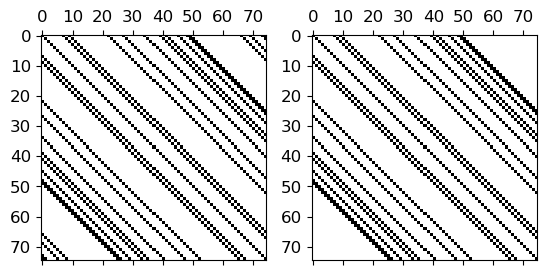

In [97]:
plt.subplot(1,2,1)
plt.spy(B_mat_symmetric(data[0]['a'], len(data[0]['a'])))
plt.subplot(1,2,2)
plt.spy(B_mat_symmetric(threshold(data[0]['a1'], 0.18), len(data[0]['a1'])))

Grid search

In [ ]:
p_values = [25, 50, 75, 100]
lambda_grid = [0.01, 0.05, 0.1, 0.2]
rho_grid = [0.5, 1.0, 2.0]

results = []

for p in p_values:
    best_loss = float('inf')
    best_params = None

    for lamb, rho in itertools.product(lambda_grid, rho_grid):
        args = SolverArgs(p=p, lambda_param=lamb, rho=rho, num_rep=10, n_samples=2000)
        solver = Solver(args)
        data = solver.solve()
        metrics = solver.evaluate(data)

        result_row = {
            'p': p,
            'lambda': lamb,
            'rho': rho,
            **metrics
        }
        results.append(result_row)

        if metrics['avg_kll'] < best_loss:
            best_loss = metrics['avg_kll']
            best_params = result_row

    print(f"Best for p={p}:", best_params)

# Save to CSV
with open('grid_search_results.csv', mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)

print("Results saved to 'grid_search_results.csv'")


In [ ]:
# Results from the 

grid_results=[
    {'p': 25, 'lambda': 0.01, 'rho': 0.5, 'avg_acc': 0.6599999999999999, 'avg_f1': 0.7228260869565217, 'avg_rate': 0.7666666666666666, 'avg_kll': 0.28834798256315786, 'avg_rkll': 0.24037572404236762, 'avg_rte': 0.010571042214066462, 'avg_fro': 14059.059954780245, 'avg_spec': 8117.548555305448, 'avg_l1': 10781.864332611367},
    {'p': 50, 'lambda': 0.01, 'rho': 0.5, 'avg_acc': 0.85, 'avg_f1': 0.6933333333333334, 'avg_rate': 0.5666666666666667, 'avg_kll': 0.39462903909416625, 'avg_rkll': 0.3780700074665795, 'avg_rte': 0.02980228052349293, 'avg_fro': 18557.711485302334, 'avg_spec': 6417.824002896113, 'avg_l1': 11958.24297119836},
    {'p': 75, 'lambda': 0.01, 'rho': 0.5, 'avg_acc': 0.9199999999999999, 'avg_f1': 0.7616191904047978, 'avg_rate': 0.6666666666666667, 'avg_kll': 0.25576180655628633, 'avg_rkll': 0.253997162116967, 'avg_rte': 0.005032227051359417, 'avg_fro': 15428.327977473476, 'avg_spec': 4211.341980301306, 'avg_l1': 8680.062740632407},
    {'p': 100, 'lambda': 0.01, 'rho': 0.5, 'avg_acc': 0.92, 'avg_f1': 0.6747181964573269, 'avg_rate': 0.5666666666666667, 'avg_kll': 0.25180667412481483, 'avg_rkll': 0.24872118039807134, 'avg_rte': 0.00969192314341527, 'avg_fro': 15987.099300046606, 'avg_spec': 3365.7288107375443, 'avg_l1': 7326.956286608768}
]

p_values = [entry['p'] for entry in grid_results]
avg_acc = [entry['avg_acc'] for entry in grid_results]
avg_f1 = [entry['avg_f1'] for entry in grid_results]
avg_rate = [entry['avg_rate'] for entry in grid_results]
avg_kll = [entry['avg_kll'] for entry in grid_results]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(p_values, avg_acc, marker='o', label='avg_acc')
plt.plot(p_values, avg_f1, marker='s', label='avg_f1')
plt.plot(p_values, avg_rate, marker='^', label='avg_rate')
plt.plot(p_values, avg_kll, marker='x', label='avg_kll')

plt.xlabel('p (dimensions)')
plt.ylabel('Value')
plt.title('Metrics vs Dimensions')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import pandas as pd

pd.DataFrame(grid_results)

Sparsity vs F1

In [ ]:
p_list = [25, 50, 75, 100 ]
d_list = [0.2, 0.4, 0.6, 0.8]
lambda_val = 0.2
rho_val = 0.1

f1_results = {p: [] for p in p_list}
metrics_list = {p: [] for p in p_list}

for p in p_list:
    for d in d_list:
        args = SolverArgs(p=p, d=int(d*p), lambda_param=lambda_val, rho=rho_val, num_rep=2)
        solver = Solver(args)
        data = solver.solve()
        metrics = solver.evaluate(data)
        metrics_list[p].append(metrics)
        f1_results[p].append(metrics['avg_f1'])

# Plotting
plt.figure(figsize=(10, 6))
for p in p_list:
    plt.plot(d_list, f1_results[p], marker='o', label=f'p={p}')

plt.xlabel('Sparsity (d)')
plt.ylabel('Average F1 Score')
plt.title('F1 Score vs Sparsity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
p_list = [25, 50, 75, 100 ]
d_list = [0.2, 0.4, 0.6, 0.8]
sparsity_metrics = {25: [{'avg_acc': 0.84,
   'avg_f1': 0.33333333333333337,
   'avg_rate': 0.2,
   'avg_kll': 1.0529756809702295,
   'avg_rkll': 1.00702370890256,
   'avg_rte': 0.07460000071462808,
   'avg_fro': 3369.3685358777766,
   'avg_spec': 1286.702401355396,
   'avg_l1': 1904.561518694909},
  {'avg_acc': 0.8999999999999999,
   'avg_f1': 0.8486842105263157,
   'avg_rate': 0.75,
   'avg_kll': 0.5338732031481239,
   'avg_rkll': 0.4468946836158363,
   'avg_rte': 0.03733322017973961,
   'avg_fro': 8496.435019246226,
   'avg_spec': 4078.0587717504623,
   'avg_l1': 6883.429269260107},
  {'avg_acc': 0.9,
   'avg_f1': 0.9125615763546798,
   'avg_rate': 0.8666666666666667,
   'avg_kll': 0.4719114912206077,
   'avg_rkll': 0.3862548576717497,
   'avg_rte': 0.03632771230451648,
   'avg_fro': 17906.665143765968,
   'avg_spec': 9987.140142796354,
   'avg_l1': 14731.903700850697},
  {'avg_acc': 0.8,
   'avg_f1': 0.888888888888889,
   'avg_rate': 1.0,
   'avg_kll': 0.35935204520121466,
   'avg_rkll': 0.27765433488975155,
   'avg_rte': 0.026490739354071702,
   'avg_fro': 26298.59003201731,
   'avg_spec': 17852.059879052955,
   'avg_l1': 23815.44598789834}],
 50: [{'avg_acc': 0.94,
   'avg_f1': 0.849624060150376,
   'avg_rate': 0.8500000000000001,
   'avg_kll': 1.2510045231720284,
   'avg_rkll': 1.1375310561003822,
   'avg_rte': 0.04146771391881243,
   'avg_fro': 14536.555443014597,
   'avg_spec': 4994.162926013361,
   'avg_l1': 7755.348548595499},
  {'avg_acc': 0.9299999999999999,
   'avg_f1': 0.9039039039039038,
   'avg_rate': 0.825,
   'avg_kll': 0.5489098523366032,
   'avg_rkll': 0.49414523592503556,
   'avg_rte': 0.020336340068476955,
   'avg_fro': 38139.20092953505,
   'avg_spec': 17488.886348052867,
   'avg_l1': 25376.78678795389},
  {'avg_acc': 0.8799999999999999,
   'avg_f1': 0.8854489164086687,
   'avg_rate': 0.8,
   'avg_kll': 0.45048465636688206,
   'avg_rkll': 0.35432468602853007,
   'avg_rte': 0.015834264085352046,
   'avg_fro': 68646.87003640598,
   'avg_spec': 42956.981967048014,
   'avg_l1': 58389.37348620994},
  {'avg_acc': 0.8,
   'avg_f1': 0.888888888888889,
   'avg_rate': 1.0,
   'avg_kll': 0.30125866386172717,
   'avg_rkll': 0.23479494800925238,
   'avg_rte': 0.01064837713347544,
   'avg_fro': 98657.53816855024,
   'avg_spec': 70542.84162575958,
   'avg_l1': 83555.5667784399}],
 75: [{'avg_acc': 0.8266666666666667,
   'avg_f1': 0.3125,
   'avg_rate': 0.23333333333333334,
   'avg_kll': 0.6924020278208189,
   'avg_rkll': 0.6506780543877326,
   'avg_rte': 0.01641496222353378,
   'avg_fro': 25043.91244947046,
   'avg_spec': 9013.495645199,
   'avg_l1': 14222.368865444594},
  {'avg_acc': 0.9133333333333333,
   'avg_f1': 0.8776223776223775,
   'avg_rate': 0.7833333333333333,
   'avg_kll': 0.6878461242358682,
   'avg_rkll': 0.5792023704491598,
   'avg_rte': 0.017004769070711134,
   'avg_fro': 90684.2025768556,
   'avg_spec': 44430.72874636037,
   'avg_l1': 64407.684438089724},
  {'avg_acc': 0.8,
   'avg_f1': 0.8228777177676222,
   'avg_rate': 0.7777777777777777,
   'avg_kll': 0.4182433695435748,
   'avg_rkll': 0.3281114274557524,
   'avg_rte': 0.009875246466152177,
   'avg_fro': 147874.24686668307,
   'avg_spec': 91978.58165048677,
   'avg_l1': 124458.24315427814},
  {'avg_acc': 0.8,
   'avg_f1': 0.888888888888889,
   'avg_rate': 1.0,
   'avg_kll': 0.3967229029107884,
   'avg_rkll': 0.2877093832410722,
   'avg_rte': 0.008772898484739278,
   'avg_fro': 240226.06071886263,
   'avg_spec': 179635.58615109482,
   'avg_l1': 205708.61006300652}],
 100: [{'avg_acc': 0.905,
   'avg_f1': 0.7298387096774194,
   'avg_rate': 0.65,
   'avg_kll': 1.129968314190485,
   'avg_rkll': 1.0340312490496615,
   'avg_rte': 0.02141936705046882,
   'avg_fro': 55118.73125915954,
   'avg_spec': 18880.351661171764,
   'avg_l1': 28715.48422370662},
  {'avg_acc': 0.9299999999999999,
   'avg_f1': 0.9124497991967871,
   'avg_rate': 0.9,
   'avg_kll': 0.558838037590121,
   'avg_rkll': 0.47168461203549583,
   'avg_rte': 0.010423304478329343,
   'avg_fro': 145273.73392863804,
   'avg_spec': 73787.03468056445,
   'avg_l1': 103888.62141929411},
  {'avg_acc': 0.835,
   'avg_f1': 0.8460471567267683,
   'avg_rate': 0.7583333333333333,
   'avg_kll': 0.4952250880787261,
   'avg_rkll': 0.3768964219970883,
   'avg_rte': 0.008359847206080295,
   'avg_fro': 281972.9328906633,
   'avg_spec': 179563.75601413613,
   'avg_l1': 220145.40615935004},
  {'avg_acc': 0.8,
   'avg_f1': 0.888888888888889,
   'avg_rate': 1.0,
   'avg_kll': 0.4079200738752391,
   'avg_rkll': 0.2975385342158958,
   'avg_rte': 0.006868991570384508,
   'avg_fro': 435704.4719963898,
   'avg_spec': 319529.38321895606,
   'avg_l1': 372844.8972469337}]}

In [ ]:
density_list = [1 - d for d in d_list]  # 1 - sparsity = density

# sparsity_metrics dictionary should be loaded here

# Initialize containers
metrics = ['avg_acc', 'avg_f1', 'avg_rate', 'avg_kll']
data_by_metric = {metric: {p: [] for p in p_list} for metric in metrics}

# Fill the data
for p in p_list:
    for metric in metrics:
        values = [sparsity_metrics[p][i][metric] for i in range(len(d_list))]
        data_by_metric[metric][p] = values

# Plot each metric separately
for metric in metrics:
    plt.figure(figsize=(8, 6))
    for p in p_list:
        plt.plot(density_list, data_by_metric[metric][p], marker='o', label=f'p={p}')
    plt.xlabel('Density (1 - Sparsity)')
    plt.ylabel(metric)
    plt.title(f'{metric} vs Density')
    plt.grid(True)
    plt.legend(title='Dimensions (p)')
    plt.show()

In [ ]:
records = []
for p in p_list:
    for i, density in enumerate(density_list):
        record = {
            'p': p,
            'density': density,
            'avg_acc': sparsity_metrics[p][i]['avg_acc'],
            'avg_f1': sparsity_metrics[p][i]['avg_f1'],
            'avg_rate': sparsity_metrics[p][i]['avg_rate'],
            'avg_kll': sparsity_metrics[p][i]['avg_kll'],
        }
        records.append(record)

# Create a DataFrame
sparsity_df = pd.DataFrame(records)

sparsity_df


In [ ]:
metrics_list

In [ ]:
f1_results

Tau vs F1

In [ ]:
p_list = [25, 50 , 75, 100]
tau = [0.01, 0.1, 1, 5, 25, 50, 100]
d_fixed = 15
lambda_val = 0.1
rho_val = 0.1

f1_results_ratio = {p: [] for p in p_list}
metrics_list = {p: [] for p in p_list}

for p in p_list:
    for t in tau:
        args = SolverArgs(p=p, d=d_fixed, const=t, lambda_param=lambda_val, rho=rho_val, num_rep=1)
        solver = Solver(args)
        data = solver.solve()
        metrics = solver.evaluate(data)
        metrics_list[p].append(metrics)
        f1_results_ratio[p].append(metrics['avg_f1'])

plt.figure(figsize=(10, 6))
for p in p_list:
    plt.plot(tau, f1_results_ratio[p], marker='o', label=f'p={p}')

plt.xlabel(r"$\tau = N/(d^2 \log p)$")
plt.ylabel('Average F1 Score')
plt.title(r'F1 Score vs $\tau$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
metrics_list

In [ ]:
for x in metrics_list[100]:
    print(x['avg_f1'])

In [ ]:
f1_results_ratio

In [ ]:
tau = [0.1, 1, 5, 10, 25, 30, 40]
p_list = [25, 50]
sparsity_res = {25: [{'avg_acc': 0.776,
   'avg_f1': 0.6862180629827689,
   'avg_rate': 0.64,
   'avg_kll': 0.32075245970498223,
   'avg_rkll': 0.29221772495036297,
   'avg_rte': 0.037881507511287583,
   'avg_fro': 7315.561270709147,
   'avg_spec': 3217.7231776224244,
   'avg_l1': 5589.952663168258},
  {'avg_acc': 0.876,
   'avg_f1': 0.8087547299621602,
   'avg_rate': 0.69,
   'avg_kll': 0.1995468663400352,
   'avg_rkll': 0.1938221190488953,
   'avg_rte': 0.03355925479886487,
   'avg_fro': 5880.659043865171,
   'avg_spec': 2493.5131865868943,
   'avg_l1': 4391.171950824877},
  {'avg_acc': 0.8640000000000001,
   'avg_f1': 0.7875952135240061,
   'avg_rate': 0.67,
   'avg_kll': 0.19863717474184278,
   'avg_rkll': 0.19079123201234188,
   'avg_rte': 0.03157514778707007,
   'avg_fro': 5907.123700543233,
   'avg_spec': 2763.7644303159846,
   'avg_l1': 4545.118262898282},
  {'avg_acc': 0.8600000000000001,
   'avg_f1': 0.7842296918767506,
   'avg_rate': 0.7,
   'avg_kll': 0.20454114233157838,
   'avg_rkll': 0.20041238024275998,
   'avg_rte': 0.03530674621826495,
   'avg_fro': 6019.083910734467,
   'avg_spec': 2706.9439029205723,
   'avg_l1': 4437.473957998895},
  {'avg_acc': 0.852,
   'avg_f1': 0.756495877703308,
   'avg_rate': 0.63,
   'avg_kll': 0.20921014822078626,
   'avg_rkll': 0.20237656893857903,
   'avg_rte': 0.031214674159102472,
   'avg_fro': 6092.930578611602,
   'avg_spec': 2661.935520275839,
   'avg_l1': 4803.98200833042},
  {'avg_acc': 0.908,
   'avg_f1': 0.8677760577915377,
   'avg_rate': 0.7699999999999999,
   'avg_kll': 0.19129500153906492,
   'avg_rkll': 0.18466497810698462,
   'avg_rte': 0.03566724867116098,
   'avg_fro': 5715.307439332556,
   'avg_spec': 2469.9343893618743,
   'avg_l1': 4244.8613397388635}],
50: [{'avg_acc': 0.78,
   'avg_f1': 0.56,
   'avg_rate': 0.4666666666666667,
   'avg_kll': 0.6200521664766683,
   'avg_rkll': 0.5536236618648545,
   'avg_rte': 0.007283350823179879,
   'avg_fro': 22713.130606109054,
   'avg_spec': 9257.041820343085,
   'avg_l1': 13177.672653895686},
  {'avg_acc': 0.92,
   'avg_f1': 0.8666666666666667,
   'avg_rate': 0.8666666666666667,
   'avg_kll': 0.4705812389505226,
   'avg_rkll': 0.446964731165977,
   'avg_rte': 0.02169433107391716,
   'avg_fro': 20716.16133367291,
   'avg_spec': 8318.918487855484,
   'avg_l1': 11522.862185665126},
  {'avg_acc': 1.0,
   'avg_f1': 1.0,
   'avg_rate': 1.0,
   'avg_kll': 0.7976771384613244,
   'avg_rkll': 0.7495273140577794,
   'avg_rte': 0.02922977117717973,
   'avg_fro': 26871.722417476358,
   'avg_spec': 10451.710785920117,
   'avg_l1': 15249.217384916557},
  {'avg_acc': 0.96,
   'avg_f1': 0.9333333333333333,
   'avg_rate': 0.9333333333333333,
   'avg_kll': 0.8826370352138895,
   'avg_rkll': 0.7930233277324774,
   'avg_rte': 0.03597123412908876,
   'avg_fro': 27049.07793792896,
   'avg_spec': 10875.932557439635,
   'avg_l1': 17049.58745419558},
  {'avg_acc': 0.98,
   'avg_f1': 0.9655172413793104,
   'avg_rate': 0.9333333333333333,
   'avg_kll': 0.5789453966178328,
   'avg_rkll': 0.5474320359200959,
   'avg_rte': 0.023121888153981418,
   'avg_fro': 22900.602260273758,
   'avg_spec': 8652.533406674294,
   'avg_l1': 13798.121398497651},
  {'avg_acc': 0.94,
   'avg_f1': 0.888888888888889,
   'avg_rate': 0.8,
   'avg_kll': 0.6416226584498119,
   'avg_rkll': 0.6054830762242318,
   'avg_rte': 0.02268897592919572,
   'avg_fro': 24159.56408691691,
   'avg_spec': 9463.873614222399,
   'avg_l1': 13856.179434700278},
  {'avg_acc': 0.94,
   'avg_f1': 0.888888888888889,
   'avg_rate': 0.8,
   'avg_kll': 0.5639035418756464,
   'avg_rkll': 0.5294221138734088,
   'avg_rte': 0.01934196321541992,
   'avg_fro': 22568.231573632962,
   'avg_spec': 9172.401101151596,
   'avg_l1': 12848.834439632374}],
}

In [ ]:
f1_scores = {p: [sparsity_res[p][i]['avg_f1'] for i in range(len(tau))] for p in p_list}

# Plot
plt.figure(figsize=(8, 6))
for p in p_list:
    plt.plot(tau, f1_scores[p], marker='o', label=f'p={p}')

plt.xlabel('tau')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Tau')
plt.grid(True)
plt.legend(title='Dimensions (p)')
plt.show()